In [63]:
from metrics import (
    SquaredError, 
    
    FunctionClassError, 
    FCErrorQuadrants,
    FCErrorOrthogonal,
    FCErrorSeenPoints,

    RegressionScore,
)
from metrics.utils import post_process
from function_classes.wrappers import (
    ScaledXRegression,
    ScaledYRegression,
    NoisyXRegression,
    NoisyYRegression,
)

from models import (
    LeastSquaresModel,
    LassoModel,
    RetrievalDictModel,
    ZeroModel,
)

from interactive import load_checkpoint_with_config

from function_classes import (
    LinearRegression,
    SparseLinearRegression,
    DecisionTreeRegression,
    Retrieval,
)

from itertools import chain
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import torch

In [64]:
NUM_BATCHES, B_SIZE, SEQ_LEN, X_DIM, Y_DIM = 2048, 64, 41, 20, 1
X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

TASK = "sparse"

RUNS = [
    # f"{TASK} gpt2", 
    f"{TASK} gpt2 (ffn)", 
    # f"{TASK} gpt2 (rope)", 
    # f"{TASK} gpt2 (rms)", 
    # f"{TASK} gpt2 (rms ffn)",
    # f"{TASK} gpt2 (rms rope)", 
    # f"{TASK} gpt2 (rope ffn)", 
    # f"{TASK} llama", 
    # f"{TASK} llama (rope ffn)", 
    # f"{TASK} llama (rope)", 
    # f"{TASK} llama (ffn)", 
    # f"{TASK} mamba",
]

chks = [
    [   
        f"../checkpoints/{run}/models/checkpoint_50000",
        f"../checkpoints/{run}/models/checkpoint_100000",
        f"../checkpoints/{run}/models/checkpoint_150000",
        # f"../checkpoints/{run}/models/checkpoint_200000",
        # f"../checkpoints/{run}/models/checkpoint_250000",
        # f"../checkpoints/{run}/models/checkpoint_300000",
        # f"../checkpoints/{run}/models/checkpoint_350000",
        # f"../checkpoints/{run}/models/checkpoint_400000",
        # f"../checkpoints/{run}/models/checkpoint_450000",
        f"../checkpoints/{run}/models/checkpoint_500000"
    ] for run in RUNS
]

CHECKPOINTS = []
for chk in chks:
    CHECKPOINTS.extend(chk)

MODEL_NAMES = [
    # # "GPT-2 50k",
    # "GPT-2 100k",
    # # "GPT-2 150k",
    # "GPT-2 200k",
    # # "GPT-2 250k",
    # "GPT-2 300k",
    # # "GPT-2 350k",
    # "GPT-2 400k",
    # # "GPT-2 450k",
    # "GPT-2 500k",

    # "GPT-2 RMS 50k",
    # "GPT-2 RMS 100k steps",
    # # "GPT-2 RMS 150k",
    # "GPT-2 RMS 200k steps",
    # # "GPT-2 RMS 250k",
    # "GPT-2 RMS 300k steps",
    # # "GPT-2 RMS 350k",
    # "GPT-2 RMS 400k steps",
    # # "GPT-2 RMS 450k",
    # "GPT-2 RMS 500k steps",

    "GPT-2 SwiGLU 50k",
    "GPT-2 SwiGLU 100k",
    "GPT-2 SwiGLU 150k",
    # "GPT-2 SwiGLU 200k",
    # "GPT-2 SwiGLU 250k",
    # "GPT-2 SwiGLU 300k",
    # "GPT-2 SwiGLU 350k",
    # "GPT-2 SwiGLU 400k",
    # "GPT-2 SwiGLU 450k",
    "GPT-2 SwiGLU 500k",

    # # "GPT-2 RMS SwiGLU 50k",
    # "GPT-2 RMS SwiGLU 100k",
    # # "GPT-2 RMS SwiGLU 150k",
    # "GPT-2 RMS SwiGLU 200k",
    # # "GPT-2 RMS SwiGLU 250k",
    # "GPT-2 RMS SwiGLU 300k",
    # # "GPT-2 RMS SwiGLU 350k",
    # "GPT-2 RMS SwiGLU 400k",
    # # "GPT-2 RMS SwiGLU 450k",
    # "GPT-2 RMS SwiGLU 500k",

    # # "Mamba 50k",
    # "Mamba 100k steps",
    # # "Mamba 150k",
    # "Mamba 200k steps",
    # # "Mamba 250k",
    # "Mamba 300k steps",
    # # "Mamba 350k",
    # "Mamba 400k steps",
    # # "Mamba 450k",
    # "Mamba 500k steps",

    "GPT-2",
    "Least Squares",
    "Lasso",
]

CONFIGS = list(chain(*map(lambda mod: [f"../checkpoints/{mod}/conf/config.yml"] * 4, RUNS)))

CHECKPOINTS.append("../checkpoints/{mod}/models/checkpoint_500000".format(mod=f"{TASK} gpt2"))
CONFIGS.append("../checkpoints/{mod}/conf/config.yml".format(mod=f"{TASK} gpt2"))

In [65]:
MODELS = [
    *[
        load_checkpoint_with_config(conf, chk_path, import_configs=False)
        for conf, chk_path in zip(CONFIGS, CHECKPOINTS)
    ],
    # RetrievalDictModel(x_dim=X_DIM, y_dim=Y_DIM),
    # ZeroModel(x_dim=X_DIM, y_dim=Y_DIM),
    LeastSquaresModel(x_dim=X_DIM, y_dim=Y_DIM),
    LassoModel(alpha=0.001, x_dim=X_DIM, y_dim=Y_DIM),
]

SCALES: list[float] = [0.125, 0.25, 0.5, 2., 4., 8.]
NOISE_LEVELS: list[float] = [0.0625, 0.125, 0.25, 0.5, 1.]

METRIC = SquaredError()

In [66]:
x_dist = MultivariateNormal(torch.zeros(X_SHAPE), torch.eye(X_DIM)) #batch size, sequence_length, x_dim
# x_dist = RetrievalDistribution(torch.Size([B_SIZE, SEQ_LEN]), torch.Size([X_DIM]))

base_fc = LinearRegression(x_dist, y_dim=Y_DIM)
# base_fc = SparseLinearRegression(x_distribution=x_dist, y_dim=Y_DIM)
# base_fc = DecisionTreeRegression(depth=4, x_distribution=x_dist, y_dim=Y_DIM)
# base_fc = Retrieval(x_dist, y_dim=Y_DIM)

bench = FunctionClassError(METRIC, function_class=base_fc)

In [69]:
errs = bench.evaluate(MODELS, num_batches=100).to('cpu')
values = list(post_process(errs))

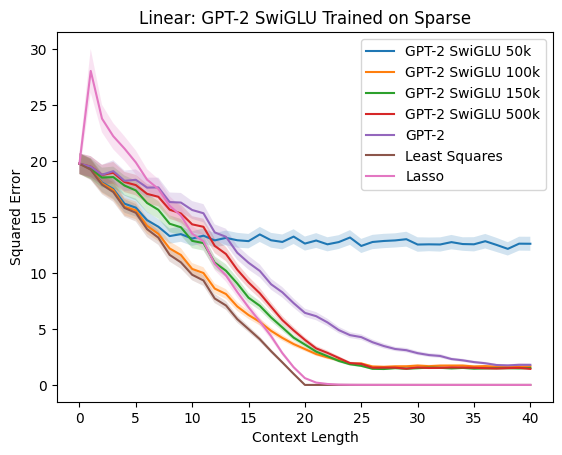

In [70]:
for name, results in zip(MODEL_NAMES, values):
    plt.plot("accuracy", data=results, label=f"{name}")
    plt.fill_between(range(41), results["confidence_0.01_lower"][:, 0], results["confidence_0.01_upper"][:, 0], alpha=0.2)

plt.ylabel(f"Squared Error")
plt.xlabel(f"Context Length")
# plt.title(f"Linear: GPT-2 RMS SwiGLU Trained on Sparse")
plt.title(f"Linear: GPT-2 SwiGLU Trained on Sparse")
# plt.title(f"Sparse Linear: GPT-2 RMS over training")
# plt.title(f"Sparse Linear: GPT-2 SwiGLU over training")
# plt.title(f"Decision Tree: Mamba over training")
# plt.title(f"Decision Tree: GPT-2 RMS over training")
# plt.legend(bbox_to_anchor=(1., 0.75))
plt.legend()
plt.show()

### Additonal, unused analysis

In [6]:
scaled_x_fcs = [
    ScaledXRegression(scale, base_fc)
    for scale in SCALES
]
scaled_in_benches = [FunctionClassError(METRIC, function_class=fc) for fc in scaled_x_fcs]

scaled_y_fcs = [
    ScaledYRegression(scale, base_fc)
    for scale in SCALES
]
scaled_out_benches = [FunctionClassError(METRIC, function_class=fc) for fc in scaled_y_fcs]

noisy_x_fcs = [
    NoisyXRegression(
        MultivariateNormal(
            torch.zeros(X_SHAPE), 
            noise_level * torch.eye(X_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_in_benches = [FunctionClassError(METRIC, function_class=fc) for fc in noisy_x_fcs]

noisy_y_fcs = [
    NoisyYRegression(
        MultivariateNormal(
            torch.zeros(Y_SHAPE), 
            noise_level * torch.eye(Y_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_out_benches = [FunctionClassError(METRIC, function_class=fc) for fc in noisy_y_fcs]

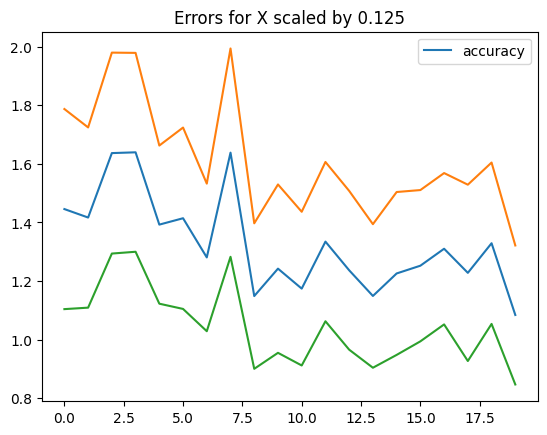

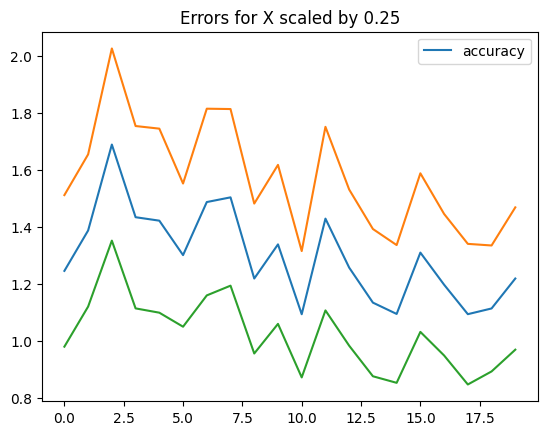

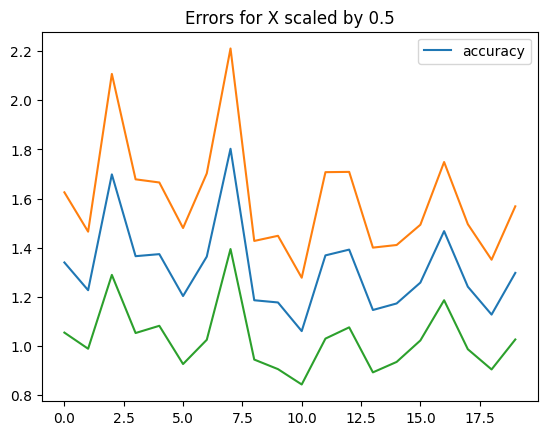

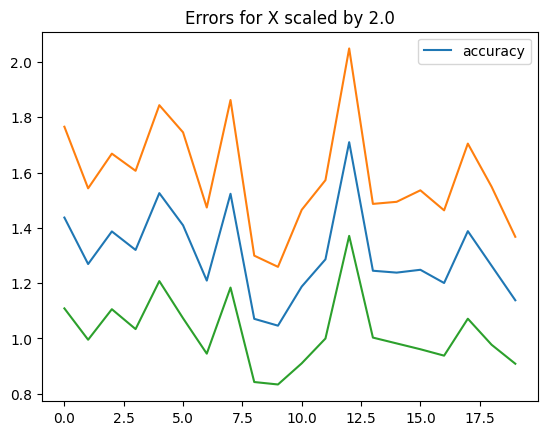

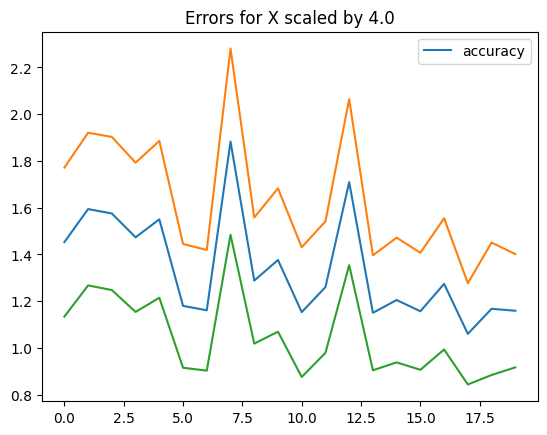

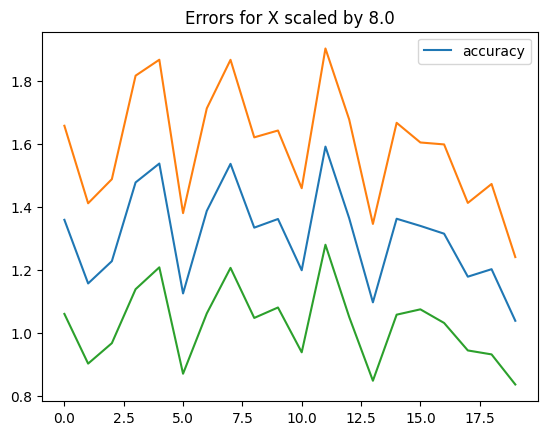

In [8]:
for b in scaled_in_benches:
    errs = b.evaluate(MODELS, num_batches=4)
    values = list(post_process(errs))
    for model, results in zip(MODELS, values):
        plt.title(f"Errors for X scaled by {b.function_class._scale}")  # pyright: ignore[reportAttributeAccessIssue]
        plt.plot("accuracy", data=results, label="accuracy")
        plt.plot("confidence_0.01_upper", data=results)
        plt.plot("confidence_0.01_lower", data=results)
        plt.legend()
        plt.show()
        break

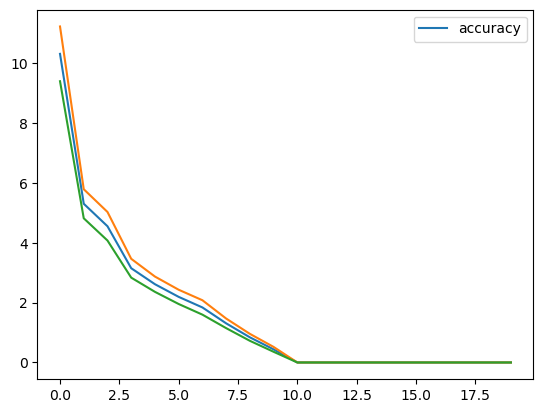

In [8]:
bench = FCErrorQuadrants(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break


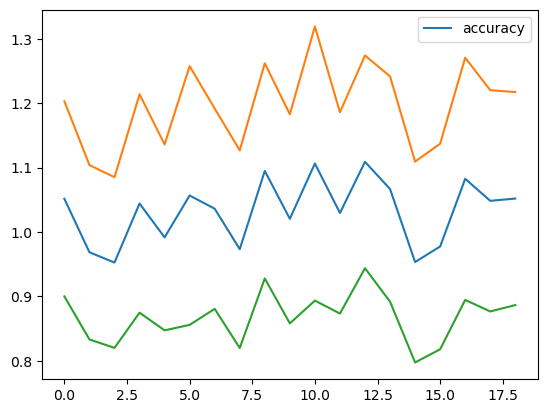

In [9]:
bench = FCErrorOrthogonal(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break

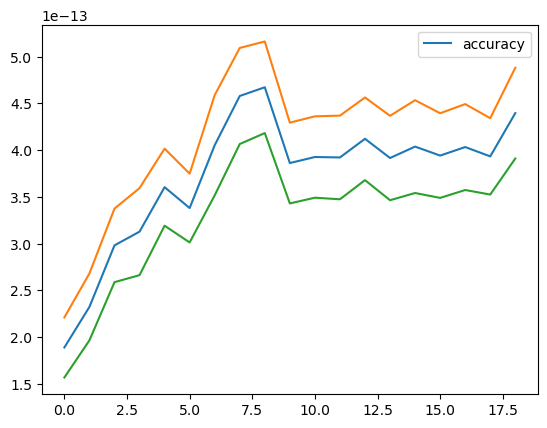

In [10]:
bench = FCErrorSeenPoints(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break